In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

In [85]:
df = pd.read_csv('D:\PROYECTOS/PREDICTOR/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Enseñamos información del dataset
print("INFORMACIÓN DEL DATASET \n")
print(df.info())

# Primeros elementos
print("\nPRIMEROS ELEMENTOS")
print(df.head())

INFORMACIÓN DEL DATASET 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [86]:
# Conversión de tipos
# Pasamos 'TotalCharges de String a float64
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df['TotalCharges'].isna().any() # Miramos si hay Nulos
# Como los hay, los cambiamos por 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

DISTRIBUCIÓN DE CHURNS: 
Churn
No     5174
Yes    1869
Name: count, dtype: int64


<Figure size 600x400 with 0 Axes>

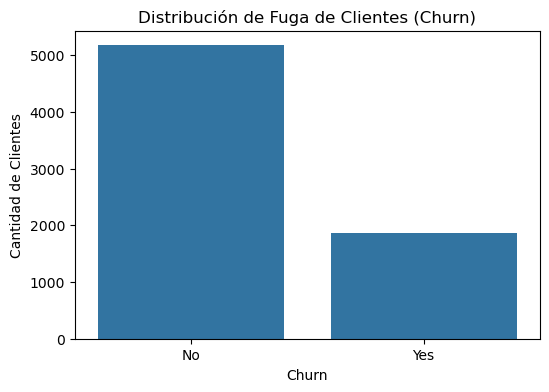

In [87]:
# Miramos si hay desbalanceo de Clases
contador_churn = df['Churn'].value_counts()
print("DISTRIBUCIÓN DE CHURNS: ")
print(contador_churn)

# Visualización
plt.figure(figsize =(6,4))
plt.figure(figsize=(6,4))
sns.barplot(x=contador_churn.index, y=contador_churn.values)
plt.title('Distribución de Fuga de Clientes (Churn)')
plt.ylabel('Cantidad de Clientes')
plt.show()

In [88]:
# La columna de ID es innecesaria, por lo que la eliminamos
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

#Nos interesa convertir los 'Yes' y 'No' de Churm en '1' y '0'
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.head()

# Diferenciamos columnas categóricad de numéricas
col_categoricas = df.select_dtypes(include=['object']).columns
col_numericas = df.select_dtypes(include = ['number']).columns.drop(['Churn'])
print(f"Columnas a transformas: {list(col_categoricas)}")

# Procedemos con el one-hot encoding
df_final = pd.get_dummies(df, columns=col_categoricas, drop_first=True)

print("\nNUEVA FORMA DEL DATASET")
print(f"Filas: {df_final.shape[0]}, Columnas: {df_final.shape[1]}")
print(df_final.head())

Columnas a transformas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

NUEVA FORMA DEL DATASET
Filas: 7043, Columnas: 31
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3       

RESUMEN CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1035
           1       0.52      0.82      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



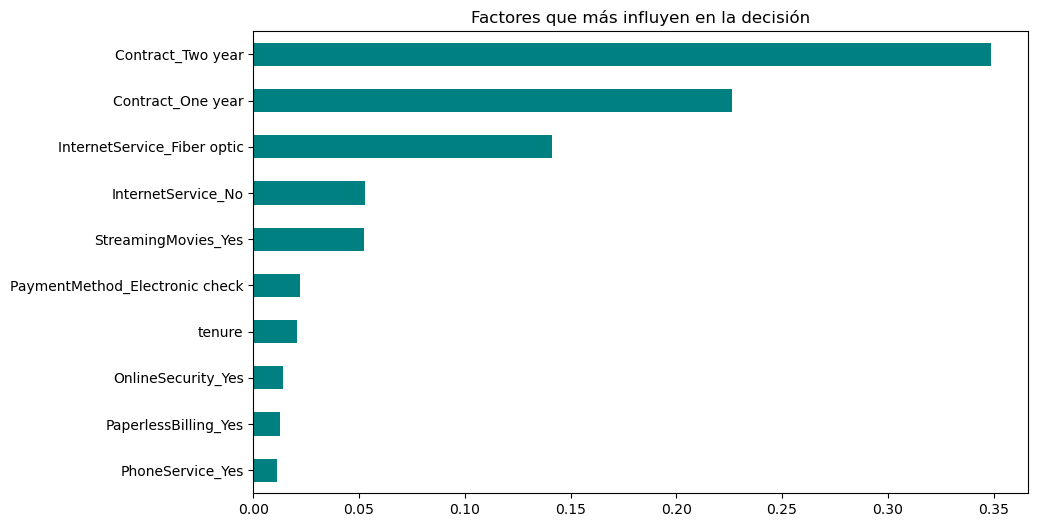

Archivos guardados en: D:\PROYECTOS\PREDICTOR\models


In [118]:
# Separamos X e y
X = df_final.drop('Churn' , axis = 1)
y = df_final['Churn']

# Dividimos en entrenamiento y en test
# stratify = y para que ambos tengan la misma proporción de fugas
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size = 0.2, random_state = 42 ,stratify = y)

# Entenamos el modelo con XGB
modelo = XGBClassifier(
    n_estimators = 100,
    max_depth = 4,
    learning_rate = 0.1,
    scale_pos_weight=3,  # Manejo de desbalanceo
    random_state=42
)
modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_test)
print("RESUMEN CLASIFICACIÓN:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,6))
caract_importantes = pd.Series(modelo.feature_importances_, index=X.columns)
caract_importantes.nlargest(10).plot(kind='barh', color='teal').invert_yaxis()
plt.title("Factores que más influyen en la decisión")
plt.show()

# Guardamos los modelos en la carpeta 'models'
folder_path =  'D:\PROYECTOS\PREDICTOR\models'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Guardamos los archivos 
joblib.dump(modelo, os.path.join(folder_path, 'modelo_churn.pkl'))
joblib.dump(list(X.columns), os.path.join(folder_path, 'columnas_modelo.pkl'))

print(f"Archivos guardados en: {os.path.abspath(folder_path)}")